In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

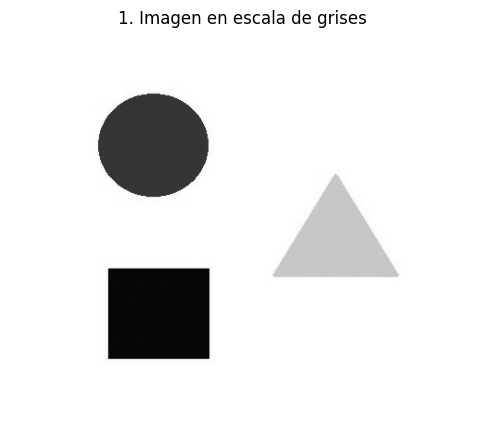

In [6]:
# Carga la imagen
script_dir = os.getcwd()
image_path = os.path.join(script_dir, 'PC.jpg')
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"No se encontró la imagen: {image_path}")

# Convertir a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Mostrar escala de grises
plt.figure(figsize=(6, 6))
plt.imshow(gray, cmap='gray')
plt.title('1. Imagen en escala de grises')
plt.axis('off')
plt.show()

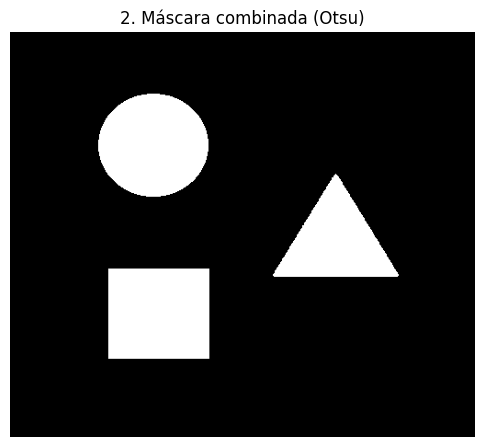

In [12]:
# Binarizar usando Otsu para formas generales
_, binary_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# Segmentación de color para amarillo claro (triángulo amarillo)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([40, 255, 255])
yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
# Combinar máscaras para captar todas las formas
binary = cv2.bitwise_or(binary_otsu, yellow_mask)
# Mostrar máscara combinada
plt.figure(figsize=(6, 6))
plt.imshow(binary, cmap='gray')
plt.title('2. Máscara combinada (Otsu)')
plt.axis('off')
plt.show()


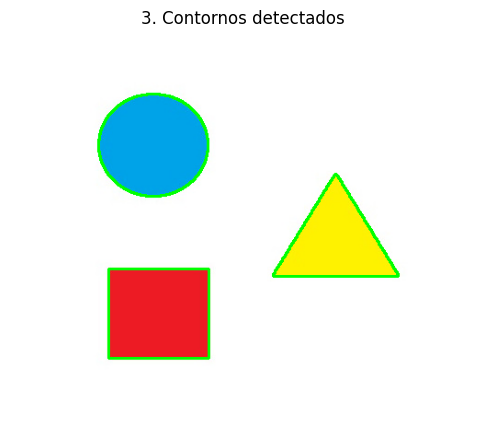

In [9]:
# Detectar contornos
contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# Visualizar contornos detectados sobre original
contour_vis = img.copy()
cv2.drawContours(contour_vis, contours, -1, (0, 255, 0), 2)
contour_vis_rgb = cv2.cvtColor(contour_vis, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(contour_vis_rgb)
plt.title('3. Contornos detectados')
plt.axis('off')
plt.show()


In [10]:
# Crear copia para dibujo
output = img.copy()
# Lista para almacenar métricas de cada figura
metrics = []

for idx, cnt in enumerate(contours, start=1):
    # Área y perímetro
    area = cv2.contourArea(cnt)
    peri = cv2.arcLength(cnt, True)

    # Calcular momentos y centroide
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx, cy = 0, 0

    # Aproximar polígono para clasificación de figura
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
    n_vertices = len(approx)
    if n_vertices == 3:
        shape = 'Triangulo'
    elif n_vertices == 4:
        # Distinguir cuadrado vs rectángulo por relación de aspecto
        x, y, w, h = cv2.boundingRect(approx)
        ar = w / float(h)
        shape = 'Cuadrado' if 0.95 <= ar <= 1.05 else 'Rectangulo'
    elif n_vertices > 4:
        shape = 'Circulo'
    else:
        shape = 'Desconocido'

    # Dibujar contorno
    cv2.drawContours(output, [cnt], -1, (0, 255, 0), 2)
    # Dibujar índice de figura junto al centroide
    cv2.putText(output, str(idx), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0, 0, 0), 2, cv2.LINE_AA)
    # Guardar métricas para la tabla
    metrics.append([idx, shape, f"{area:.1f}", f"{peri:.1f}", cx, cy])

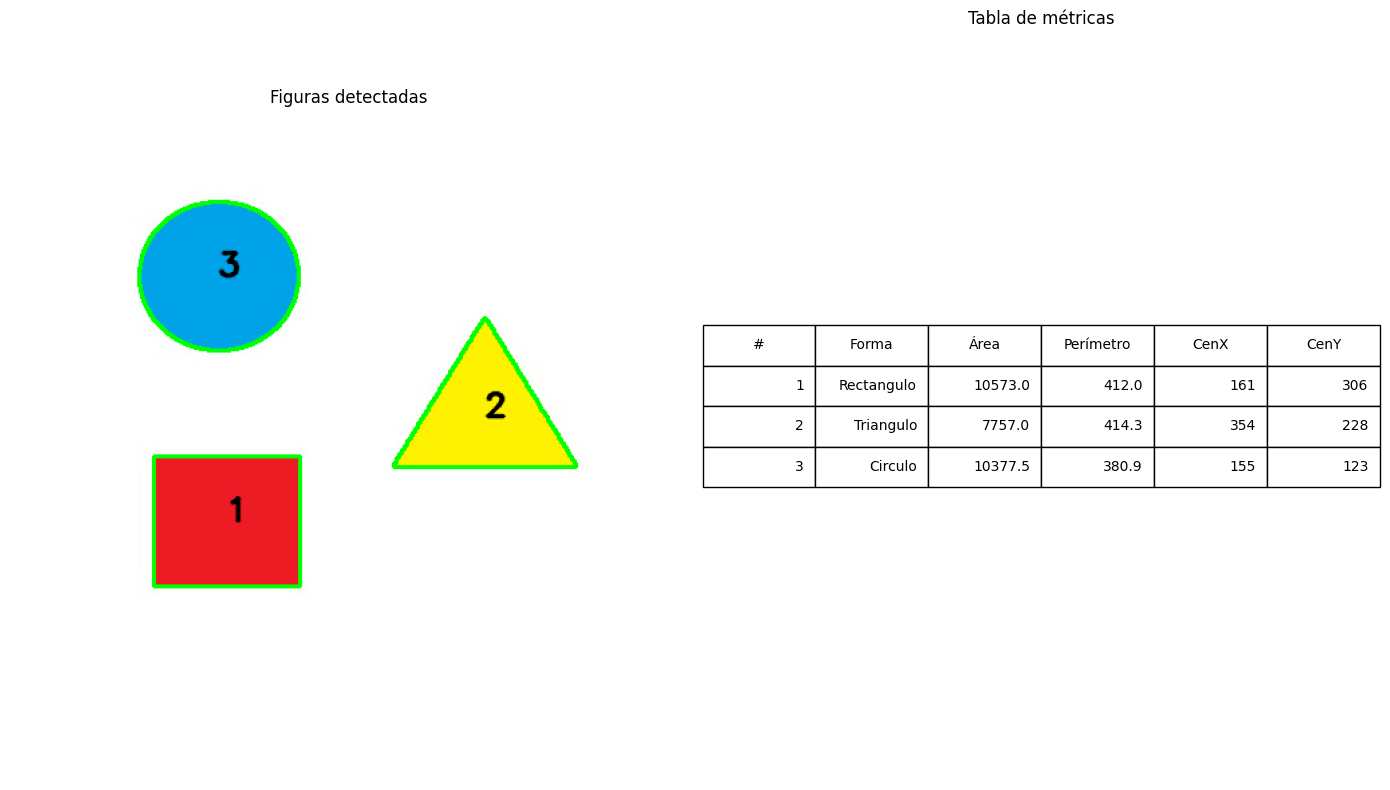

In [11]:
# Mostrar resultado con Matplotlib y tabla de métricas
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
ax1.imshow(output_rgb)
ax1.axis('off')
ax1.set_title('Figuras detectadas')

# Crear tabla de métricas
col_labels = ['#', 'Forma', 'Área', 'Perímetro', 'CenX', 'CenY']
ax2.axis('off')
table = ax2.table(cellText=metrics, colLabels=col_labels, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax2.set_title('Tabla de métricas')
plt.tight_layout()
plt.show()